# Customer and Article Data Analysis

This notebook performs data analysis on customer, article, and transaction datasets. The workflow includes data loading, cleaning, transformation, and visualization.

## Imports and Settings
We start by importing necessary libraries and setting up the environment.

## Data Loading
Load customer, article, and transaction data from CSV files.

## Data Exploration and Cleaning
### Customers
- Check for missing values and fill them.
- Create age intervals for customers.

### Articles
- Check for missing values and fill them.
- Explore unique values in article columns.
- Select relevant columns for analysis.

### Transactions
- Check for missing values.
- Explore sales channel distribution.
- Visualize price distribution.

## Saving Processed Data
Save the cleaned and transformed data for future use as pcikle files.

In [2]:
# Standard library imports
import os
import datetime
import pickle
import time
from glob import glob
from typing import Dict, List, Optional, Set, Tuple

# Third party imports
import numpy as np
import pandas as pd
import implicit
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix, vstack
from scipy.sparse.linalg import svds
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# Local imports
from Utils.utils import visualize_bought, visualize_candidates
from Models.collaborative_filtering import ALSRecommender, SVDRecommender

# Settings
os.environ['OPENBLAS_NUM_THREADS'] = '1' # Prevents OpenBLAS from using multiple threads
pd.set_option('display.max_columns', 500)

In [3]:
# Load data
customers = pd.read_csv("data/customers.csv", dtype={'customer_id':str}, usecols=['customer_id', 'age'])
articles = pd.read_csv("data/articles.csv", dtype={'article_id':str})
transactions = pd.read_csv("data/transactions_train.csv", dtype={'article_id':str})

In [4]:
print("Shape of customers:", customers.shape)
print("Shape of articles:", articles.shape)
print("Shape of transactions:", transactions.shape)

Shape of customers: (1371980, 2)
Shape of articles: (105542, 25)
Shape of transactions: (31788324, 5)


In [5]:
customers.isnull().sum()

customer_id        0
age            15861
dtype: int64

In [6]:
customers["age"] = customers["age"].fillna(customers["age"].median())

In [7]:
def create_age_interval(x):
    if x <= 25:
        return 0
    elif x <= 35:
        return 1
    elif x <= 45:
        return 2
    elif x <= 55:
        return 3
    elif x <= 65:
        return 4
    else:
        return 5

In [8]:
customers["age_interval"] = customers["age"].apply(create_age_interval)
customers.head()

,customer_id,age,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49.0,3
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25.0,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24.0,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54.0,3
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52.0,3


In [9]:
articles.isnull().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [10]:
articles['detail_desc'] = articles['detail_desc'].fillna("")

In [11]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [12]:
for col in articles.columns:
    print(f"Number of unique values in {col}:", articles[col].nunique())

Number of unique values in article_id: 105542
Number of unique values in product_code: 47224
Number of unique values in prod_name: 45875
Number of unique values in product_type_no: 132
Number of unique values in product_type_name: 131
Number of unique values in product_group_name: 19
Number of unique values in graphical_appearance_no: 30
Number of unique values in graphical_appearance_name: 30
Number of unique values in colour_group_code: 50
Number of unique values in colour_group_name: 50
Number of unique values in perceived_colour_value_id: 8
Number of unique values in perceived_colour_value_name: 8
Number of unique values in perceived_colour_master_id: 20
Number of unique values in perceived_colour_master_name: 20
Number of unique values in department_no: 299
Number of unique values in department_name: 250
Number of unique values in index_code: 10
Number of unique values in index_name: 10
Number of unique values in index_group_no: 5
Number of unique values in index_group_name: 5
Num

In [13]:
articles = articles[['article_id', 'product_type_no', 'product_type_name', 'product_group_name', 'garment_group_no', 'garment_group_name', 'colour_group_code', 'colour_group_name', 'section_no', 'section_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'detail_desc']]

In [14]:
articles.head()

,article_id,product_type_no,product_type_name,product_group_name,garment_group_no,garment_group_name,colour_group_code,colour_group_name,section_no,section_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,detail_desc
0,0108775015,253,Vest top,Garment Upper body,1002,Jersey Basic,9,Black,16,Womens Everyday Basics,4,Dark,5,Black,Jersey top with narrow shoulder straps.
1,0108775044,253,Vest top,Garment Upper body,1002,Jersey Basic,10,White,16,Womens Everyday Basics,3,Light,9,White,Jersey top with narrow shoulder straps.
2,0108775051,253,Vest top,Garment Upper body,1002,Jersey Basic,11,Off White,16,Womens Everyday Basics,1,Dusty Light,9,White,Jersey top with narrow shoulder straps.
3,0110065001,306,Bra,Underwear,1017,"Under-, Nightwear",9,Black,61,Womens Lingerie,4,Dark,5,Black,"Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,306,Bra,Underwear,1017,"Under-, Nightwear",10,White,61,Womens Lingerie,3,Light,9,White,"Microfibre T-shirt bra with underwired, moulde..."


In [15]:
transactions.isnull().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

In [16]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


In [17]:
transactions['sales_channel_id'].value_counts()

sales_channel_id
2    22379862
1     9408462
Name: count, dtype: int64

<Axes: title={'center': 'Price distribution'}, ylabel='Frequency'>

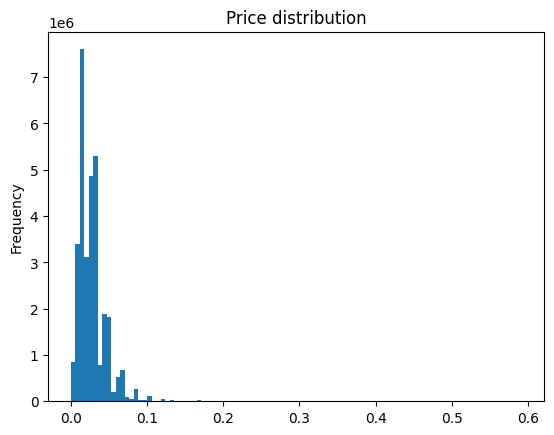

In [18]:
transactions['price'].plot(kind='hist', bins=100, title='Price distribution')

In [19]:
images = glob("Data/images/*/*", recursive=True)
image_ids = pd.DataFrame([{'image_id': image.split('/')[-1].split('.')[0], 'path': image} for image in images])

In [20]:
image_ids

,image_id,path
0,images\010\0108775015,Data/images\010\0108775015.jpg
1,images\010\0108775044,Data/images\010\0108775044.jpg
2,images\010\0108775051,Data/images\010\0108775051.jpg
3,images\011\0110065001,Data/images\011\0110065001.jpg
4,images\011\0110065002,Data/images\011\0110065002.jpg
...,...,...
105095,images\095\0953450001,Data/images\095\0953450001.jpg
105096,images\095\0953763001,Data/images\095\0953763001.jpg
105097,images\095\0956217002,Data/images\095\0956217002.jpg
105098,images\095\0957375001,Data/images\095\0957375001.jpg


In [21]:
articles['product_type_no'].unique()

array([253, 306, 304, 302, 273, 252, 254, 272,  72, 532, 295, 256,  73,
        -1, 308, 196,  74,  67,  87, 298,  59, 286,  57, 275, 255, 265,
        75, 307, 274, 259,  69, 297,  94,  81, 245,  71,  70,  66, 264,
        89, 267,  91, 262,  83, 277, 305,  80, 263,  78, 257,  93, 293,
       495, 515,  76, 260,  77,  86,  82, 296, 509,  68, 258, 271,  85,
       283, 496, 161,  49, 268, 276,  84, 299,  60, 144, 270,  79, 156,
        95, 287, 261,  90,  88, 499, 100,  98,  92, 289,  96, 155, 512,
       284, 291, 285, 288, 300, 303, 349, 511, 475, 477, 351, 467, 508,
       503, 465, 230, 504, 476, 326, 494, 514, 498, 525, 231, 492, 489,
       470, 102, 366, 493, 762, 529, 464, 389, 761, 468, 521, 510, 523,
       491, 483], dtype=int64)

In [22]:
# Customers
customers['customer_id'] = customers['customer_id'].astype('string')
customers['age'] = customers['age'].astype('int8')
customers['age_interval'] = customers['age_interval'].astype('int8')

# Articles
articles['article_id'] = articles['article_id'].astype('string')
articles['product_type_no'] = articles['product_type_no'].astype('int16')  
articles['product_type_name'] = articles['product_type_name'].astype('category')
articles['product_group_name'] = articles['product_group_name'].astype('category')
articles['garment_group_no'] = articles['garment_group_no'].astype('int16')  
articles['garment_group_name'] = articles['garment_group_name'].astype('category')
articles['colour_group_code'] = articles['colour_group_code'].astype('int16')  
articles['colour_group_name'] = articles['colour_group_name'].astype('category')
articles['section_no'] = articles['section_no'].astype('int16') 
articles['section_name'] = articles['section_name'].astype('category')
articles['perceived_colour_value_id'] = articles['perceived_colour_value_id'].astype('int16')
articles['perceived_colour_value_name'] = articles['perceived_colour_value_name'].astype('category')
articles['perceived_colour_master_id'] = articles['perceived_colour_master_id'].astype('int16') 
articles['perceived_colour_master_name'] = articles['perceived_colour_master_name'].astype('category')
articles['detail_desc'] = articles['detail_desc'].astype('string') 

# Transactions
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['customer_id'] = transactions['customer_id'].astype('string')  
transactions['article_id'] = transactions['article_id'].astype('string') 
transactions['sales_channel_id'] = transactions['sales_channel_id'].astype('int8') 
transactions['price'] = transactions['price'].astype('float32')  


In [23]:
customers.dtypes

customer_id     string[python]
age                       int8
age_interval              int8
dtype: object

In [24]:
articles.dtypes

article_id                      string[python]
product_type_no                          int16
product_type_name                     category
product_group_name                    category
garment_group_no                         int16
garment_group_name                    category
colour_group_code                        int16
colour_group_name                     category
section_no                               int16
section_name                          category
perceived_colour_value_id                int16
perceived_colour_value_name           category
perceived_colour_master_id               int16
perceived_colour_master_name          category
detail_desc                     string[python]
dtype: object

In [25]:
transactions.dtypes

t_dat               datetime64[ns]
customer_id         string[python]
article_id          string[python]
price                      float32
sales_channel_id              int8
dtype: object

In [26]:
# Save data
customers.to_pickle("data/customers.pkl")
articles.to_pickle("data/articles.pkl")
transactions.to_pickle("data/transactions.pkl")